# **Machine Learning Operations Final Project: Exploratory Data Analysis**
Group Members:
- **Bradley Stoller**
- **Samuel Martinez Koss**
- **Xigang Zhang**
- **Zhiwei Guo**

## **Import Library**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from io import StringIO
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_recall_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

## **Data Loading**

In [13]:
# Set up official Pokemon type colors for visualization
pokemon_type_colors = {
    'Normal': '#A8A77A',   # Gray-brown
    'Fire': '#EE8130',     # Orange-red
    'Water': '#6390F0',    # Blue
    'Electric': '#F7D02C', # Yellow
    'Grass': '#7AC74C',    # Green
    'Ice': '#96D9D6',      # Light blue
    'Fighting': '#C22E28', # Dark red
    'Poison': '#A33EA1',   # Purple
    'Ground': '#E2BF65',   # Tan
    'Flying': '#A98FF3',   # Light purple
    'Psychic': '#F95587',  # Pink
    'Bug': '#A6B91A',      # Yellow-green
    'Rock': '#B6A136',     # Brown
    'Ghost': '#735797',    # Purple
    'Dragon': '#6F35FC',   # Dark blue
    'Dark': '#705746',     # Dark brown
    'Steel': '#B7B7CE',    # Gray
    'Fairy': '#D685AD'     # Light pink
}

# Create a custom color palette for our plots
pokemon_palette = list(pokemon_type_colors.values())

# Load the dataset
pokemon_df = pd.read_csv('pokemon_data_science.csv')

# Display basic information about the dataset
print(f"Dataset Shape: {pokemon_df.shape}")
pokemon_df.info()
pokemon_df.head()

Dataset Shape: (721, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Number            721 non-null    int64  
 1   Name              721 non-null    object 
 2   Type_1            721 non-null    object 
 3   Type_2            350 non-null    object 
 4   Total             721 non-null    int64  
 5   HP                721 non-null    int64  
 6   Attack            721 non-null    int64  
 7   Defense           721 non-null    int64  
 8   Sp_Atk            721 non-null    int64  
 9   Sp_Def            721 non-null    int64  
 10  Speed             721 non-null    int64  
 11  Generation        721 non-null    int64  
 12  isLegendary       721 non-null    bool   
 13  Color             721 non-null    object 
 14  hasGender         721 non-null    bool   
 15  Pr_Male           644 non-null    float64
 16  Egg_Group_1       7

,Number,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,...,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,...,Green,True,0.875,Monster,Grass,False,0.71,6.9,45,quadruped
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,...,Green,True,0.875,Monster,Grass,False,0.99,13.0,45,quadruped
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,...,Green,True,0.875,Monster,Grass,True,2.01,100.0,45,quadruped
3,4,Charmander,Fire,NaN,309,39,52,43,60,50,...,Red,True,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed
4,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,...,Red,True,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed


## **Exploratory Data Analysis (EDA)**

      Type_1        Name  Total
0        Bug    Genesect    600
1        Bug   Volcarona    550
2        Bug     Yanmega    515
3       Dark     Yveltal    680
4       Dark     Darkrai    600
5       Dark   Hydreigon    600
6     Dragon    Rayquaza    680
7     Dragon    Reshiram    680
8     Dragon      Zekrom    680
9   Electric      Zapdos    580
10  Electric      Raikou    580
11  Electric   Thundurus    580
12     Fairy     Xerneas    680
13     Fairy     Florges    552
14     Fairy    Togekiss    545
15  Fighting     Lucario    525
16  Fighting    Mienshao    510
17  Fighting     Machamp    505
18      Fire       Ho-Oh    680
19      Fire     Heatran    600
20      Fire   Volcanion    600
21    Flying    Tornadus    580
22    Flying     Noivern    535
23    Flying      Noibat    245
24     Ghost    Giratina    680
25     Ghost    Dusknoir    525
26     Ghost  Chandelure    520
27     Grass     Shaymin    600
28     Grass    Virizion    580
29     Grass   Tangrowth    535
30    Gr

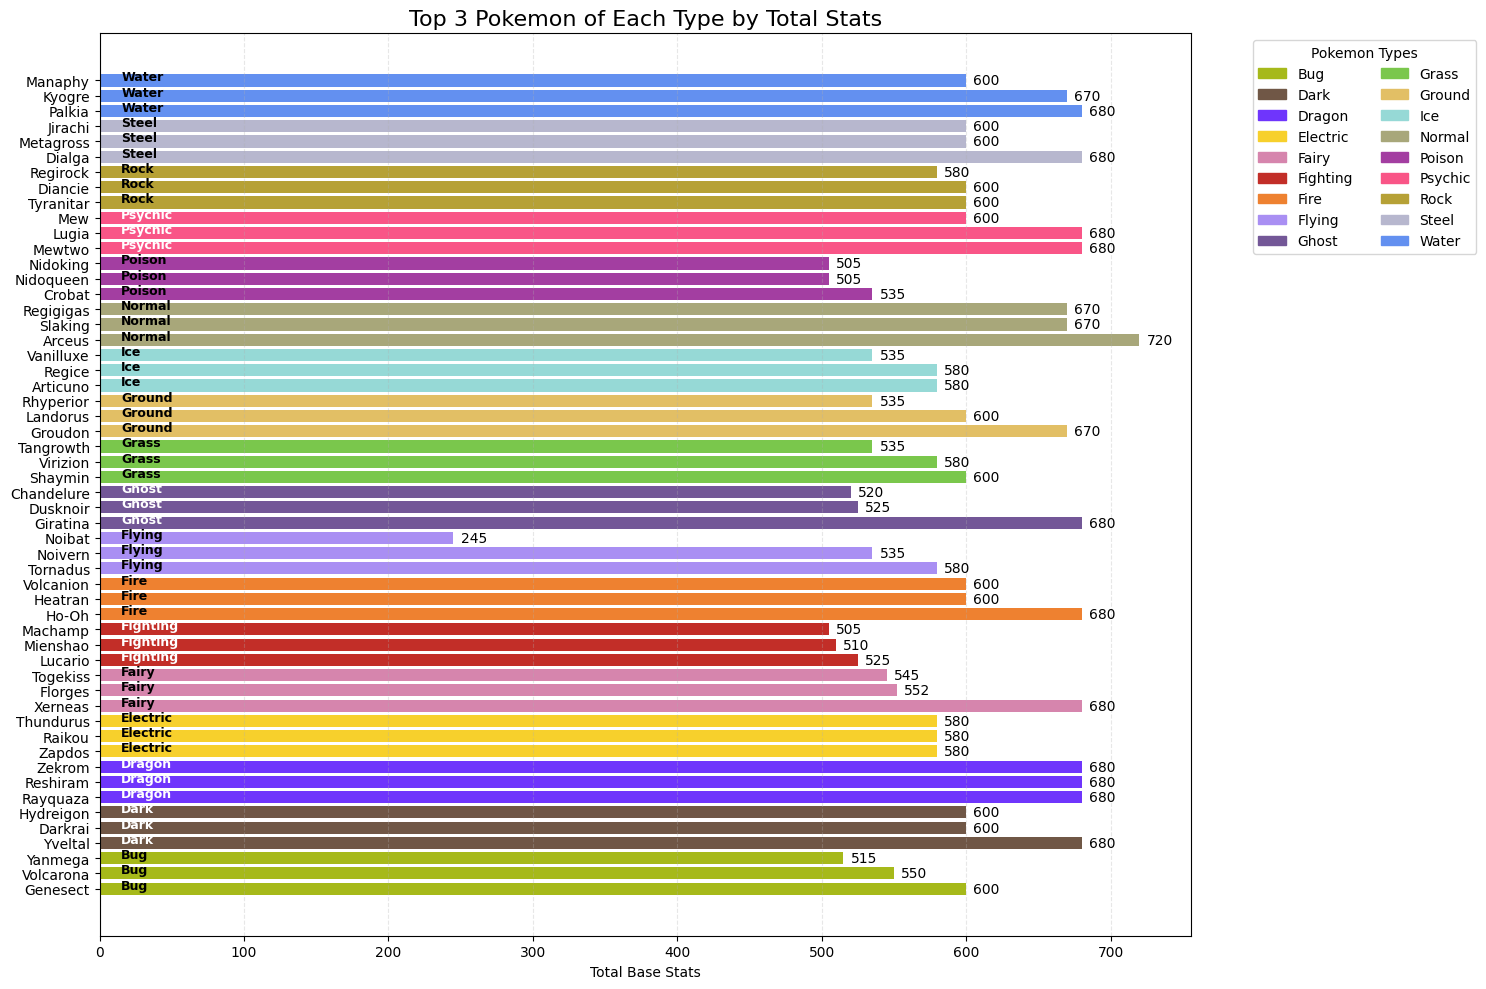

In [14]:
# Create an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Write the DataFrame to a SQL table
pokemon_df.to_sql('PokemonStats', conn, index=False)

# SQL query to find top 3 Pokemon of each type by total stats
query = """
-- Find the top 3 Pokémon of each primary type based on total stats
SELECT
    Type_1,
    Name,
    Total
FROM (
    SELECT
        Type_1,
        Name,
        Total,
        ROW_NUMBER() OVER (PARTITION BY Type_1 ORDER BY Total DESC) as rank_within_type
    FROM PokemonStats
) ranked
WHERE rank_within_type <= 3
ORDER BY Type_1, Total DESC;
"""

# Execute the query and load results into a DataFrame
result_df = pd.read_sql_query(query, conn)

# Display the results
print(result_df)

# Create a bar plot of the top Pokemon by type with official type colors
plt.figure(figsize=(15, 10))

# Get a copy of the results dataframe for manipulation
top_pokemon = result_df.copy()

# Create a categorical color map based on Type_1
type_colors = [pokemon_type_colors.get(t, '#AAAAAA') for t in top_pokemon['Type_1']]

# Create the bar plot
bars = plt.barh(y=top_pokemon['Name'], width=top_pokemon['Total'], color=type_colors)

# Add Pokemon type as text inside or next to each bar
for i, (name, type1, total) in enumerate(zip(top_pokemon['Name'], top_pokemon['Type_1'], top_pokemon['Total'])):
    text_color = 'white' if type1 in ['Ghost', 'Dragon', 'Dark', 'Fighting', 'Psychic'] else 'black'
    plt.text(15, i, f"{type1}", fontsize=9, fontweight='bold', color=text_color)
    plt.text(total + 5, i, f"{total}", va='center')

plt.title('Top 3 Pokemon of Each Type by Total Stats', fontsize=16)
plt.xlabel('Total Base Stats')
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Create a custom legend with Pokemon type colors
handles = [plt.Rectangle((0, 0), 1, 1, color=pokemon_type_colors[t])
           for t in sorted(pokemon_type_colors.keys())]
plt.legend(handles, sorted(pokemon_type_colors.keys()), title="Pokemon Types",
           bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

# Close the connection
conn.close()


Average Stats by Type (Sorted by Total):
          Total    HP  Attack  Defense  Sp_Atk  Sp_Def  Speed  Count  \
Type_1                                                                 
Dragon    502.0  78.0   102.6     79.1    82.5    83.0   76.7     24   
Steel     464.9  64.8    83.5    119.4    63.5    79.4   54.2     22   
Flying    453.3  68.0    71.7     61.7    89.0    66.7   96.3      3   
Fire      443.0  68.6    82.2     64.9    83.5    69.5   74.4     47   
Psychic   442.5  70.6    61.3     65.0    90.6    82.4   72.6     47   
Rock      437.8  64.5    88.5     99.8    60.0    73.1   51.9     41   
Dark      434.8  67.2    86.2     67.9    70.5    67.5   75.4     28   
Ice       427.1  71.7    70.7     71.0    75.7    76.1   61.9     23   
Ghost     423.7  61.6    67.5     76.0    81.3    76.5   60.8     23   
Ground    421.0  72.4    91.3     82.2    51.7    61.3   62.1     30   
Electric  420.7  59.5    67.8     59.1    83.1    67.7   83.5     36   
Water     417.2  70.9  

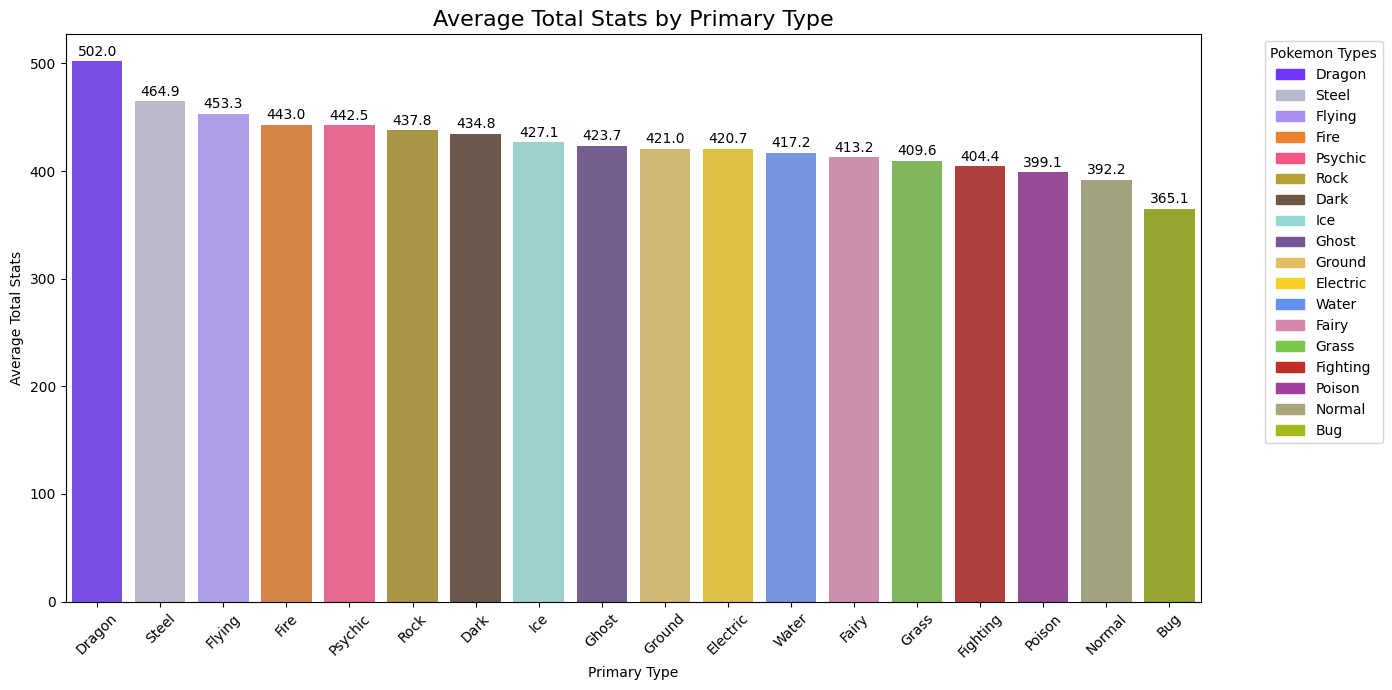

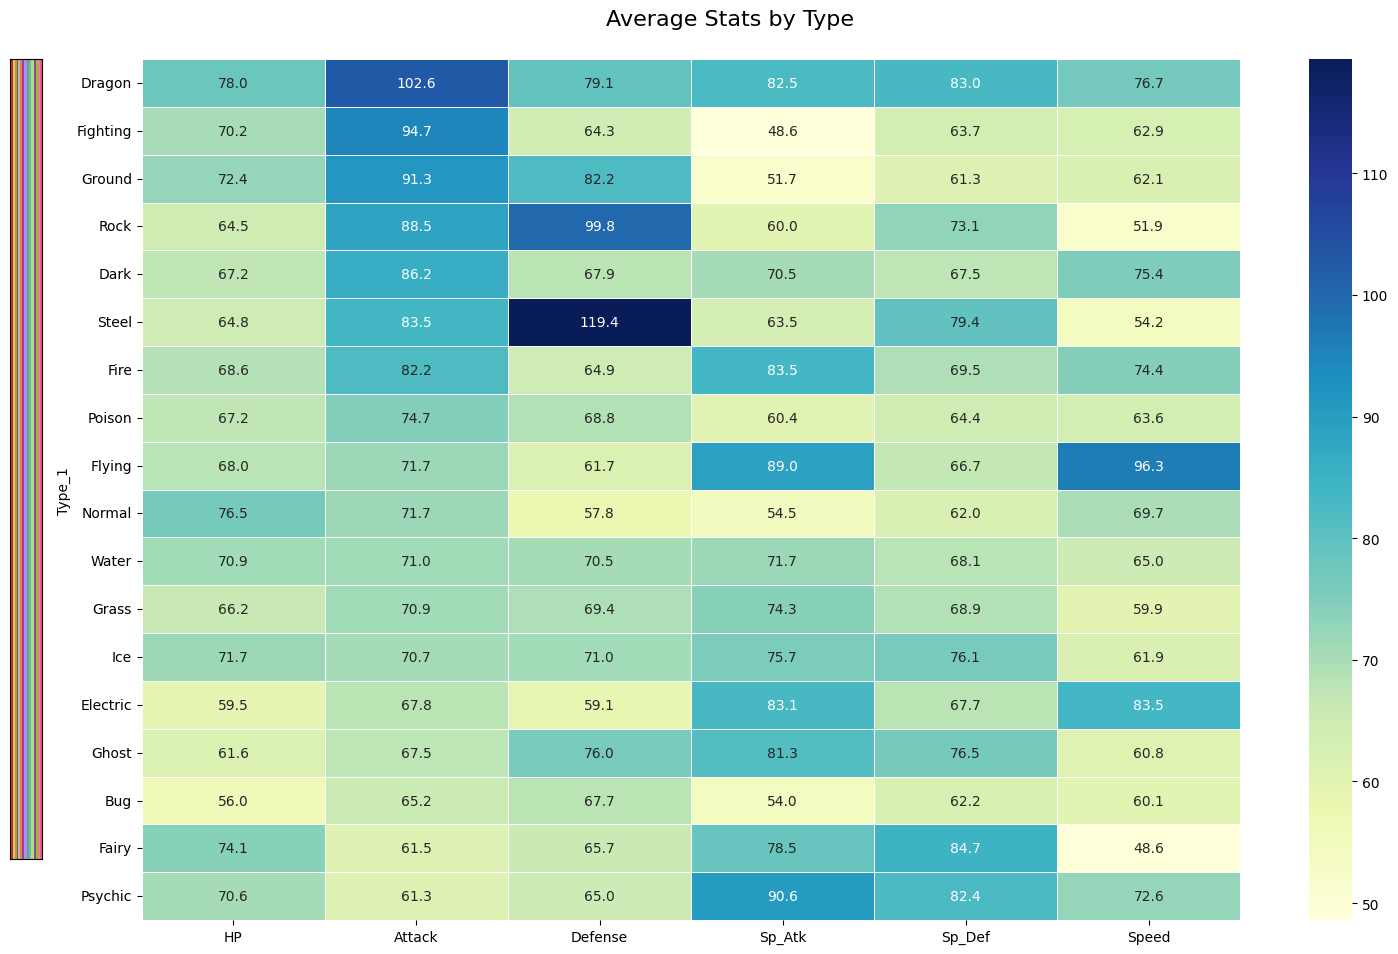

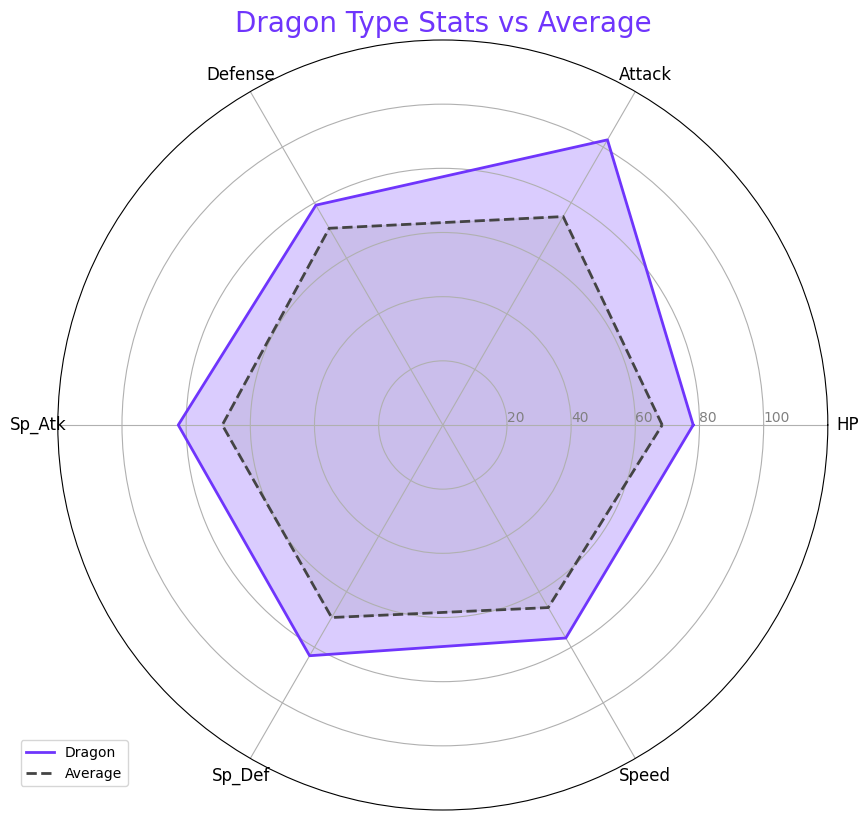

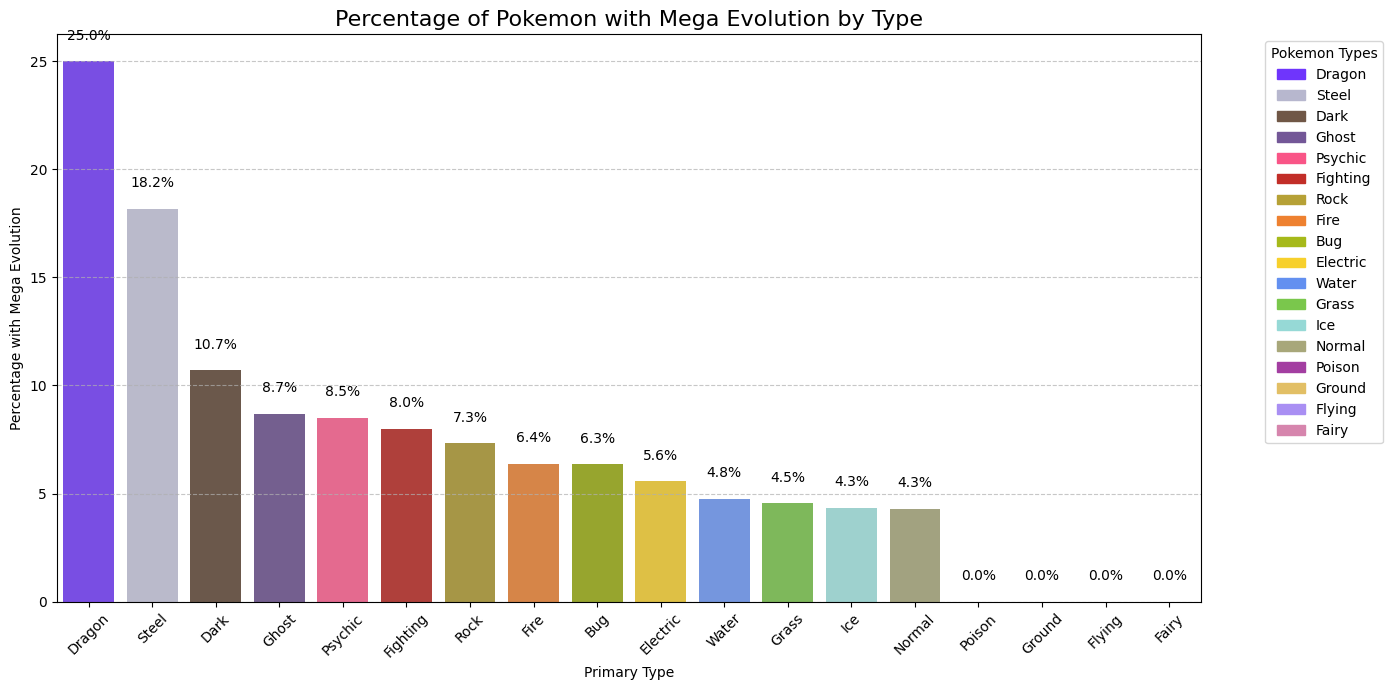

In [15]:
# Calculate average stats by type
type_stats = pokemon_df.groupby('Type_1').agg({
    'Total': 'mean',
    'HP': 'mean',
    'Attack': 'mean',
    'Defense': 'mean',
    'Sp_Atk': 'mean',
    'Sp_Def': 'mean',
    'Speed': 'mean',
    'Number': 'count'  # Count for number of Pokémon
}).rename(columns={'Number': 'Count'}).sort_values('Total', ascending=False)

# Round all numerical columns to 1 decimal place
for col in ['Total', 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed']:
    type_stats[col] = type_stats[col].round(1)

# Calculate legendary count by type
type_legendary = pokemon_df[pokemon_df['isLegendary']].groupby('Type_1').size()
type_stats['Legendary_Count'] = type_legendary

# Calculate percentage of legendary Pokemon by type
type_stats['Legendary_Percentage'] = (type_stats['Legendary_Count'] / type_stats['Count'] * 100).round(2)

# Display the type stats
print("Average Stats by Type (Sorted by Total):")
print(type_stats)

# Plot average total stats by type
plt.figure(figsize=(14, 7))
bars = sns.barplot(x=type_stats.index, y=type_stats['Total'],
                  palette=[pokemon_type_colors.get(t, '#AAAAAA') for t in type_stats.index])
plt.title('Average Total Stats by Primary Type', fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('Average Total Stats')
plt.xlabel('Primary Type')

# Add value labels on top of each bar
for i, v in enumerate(type_stats['Total']):
    plt.text(i, v + 5, f"{v:.1f}", ha='center')

# Add a legend with type colors
handles = [plt.Rectangle((0, 0), 1, 1, color=pokemon_type_colors[t]) for t in type_stats.index]
plt.legend(handles, type_stats.index, title="Pokemon Types",
           bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Create a heatmap of the average stats by type with custom colors
stat_columns = ['HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed']
plt.figure(figsize=(16, 10))

# Sort by attack for better visualization
sorted_types = type_stats[stat_columns].sort_values('Attack', ascending=False)

# Create a custom colormap using Pokemon type colors for the row colors
row_colors = [pokemon_type_colors.get(t, '#AAAAAA') for t in sorted_types.index]

# Create the heatmap with row colors
sns.heatmap(sorted_types, annot=True, fmt=".1f", cmap="YlGnBu",
            linewidths=.5, yticklabels=sorted_types.index)

# Add row colors as a separate axis on the left
ax_row_colors = plt.axes([0.05, 0.1, 0.02, 0.8])  # position [left, bottom, width, height]
ax_row_colors.pcolor([np.arange(len(row_colors))], cmap=plt.cm.colors.ListedColormap(row_colors))
ax_row_colors.set_xticks([])
ax_row_colors.set_yticks([])

plt.suptitle('Average Stats by Type', fontsize=16, y=0.95)
plt.tight_layout(rect=[0.07, 0, 1, 0.95])  # Adjust the main plot to make room for the row colors
plt.show()

# Create a radar chart for Dragon type stats compared to average with Pokemon type colors
# Get the average stats across all Pokemon
all_avg = pokemon_df[stat_columns].mean()
# Get Dragon type stats
dragon_stats = pokemon_df[pokemon_df['Type_1'] == 'Dragon'][stat_columns].mean()

# Prepare data for radar chart
stats = pd.DataFrame({
    'Attribute': stat_columns,
    'Dragon': dragon_stats.values,
    'Average': all_avg.values
})

# Create a radar chart
categories = stat_columns
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

# Number of categories
N = len(categories)
# What will be the angle of each axis
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Draw the axes
plt.xticks(angles[:-1], categories, size=12)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([20, 40, 60, 80, 100], ["20", "40", "60", "80", "100"], color="grey", size=10)
plt.ylim(0, 120)

# Plot data
values = dragon_stats.values.flatten().tolist()
values += values[:1]  # Close the loop
ax.plot(angles, values, linewidth=2, linestyle='solid', label="Dragon",
        color=pokemon_type_colors['Dragon'])  # Use Dragon's official color
ax.fill(angles, values, alpha=0.25, color=pokemon_type_colors['Dragon'])

# Add average values for comparison
values = all_avg.values.flatten().tolist()
values += values[:1]  # Close the loop
ax.plot(angles, values, linewidth=2, linestyle='dashed', label="Average", color='#444444')
ax.fill(angles, values, alpha=0.1, color='#444444')

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title("Dragon Type Stats vs Average", size=20, color=pokemon_type_colors['Dragon'])
plt.show()

# NOTE: The type distribution by generation plot has been removed as requested

# We still keep the type_gen_count calculation for potential use in other analyses
type_gen_count = pd.crosstab(pokemon_df['Type_1'], pokemon_df['Generation'])
type_gen_count['Total'] = type_gen_count.sum(axis=1)
type_gen_count = type_gen_count.sort_values('Total', ascending=False)

# Analyze Mega Evolution capability by type with official colors
mega_by_type = pokemon_df.groupby('Type_1')['hasMegaEvolution'].agg(['sum', 'count'])
mega_by_type['percentage'] = (mega_by_type['sum'] / mega_by_type['count'] * 100).round(2)
mega_by_type = mega_by_type.sort_values('percentage', ascending=False)

plt.figure(figsize=(14, 7))
bars = sns.barplot(x=mega_by_type.index, y=mega_by_type['percentage'],
                  palette=[pokemon_type_colors.get(t, '#AAAAAA') for t in mega_by_type.index])

# Add value labels on top of each bar
for i, v in enumerate(mega_by_type['percentage']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.title('Percentage of Pokemon with Mega Evolution by Type', fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('Percentage with Mega Evolution')
plt.xlabel('Primary Type')

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend with type colors
handles = [plt.Rectangle((0, 0), 1, 1, color=pokemon_type_colors[t]) for t in mega_by_type.index]
plt.legend(handles, mega_by_type.index, title="Pokemon Types",
           bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
# Perform ANOVA analysis to check if type differences are statistically significant
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Create groups for ANOVA
groups = []
group_labels = []
for type_name, group in pokemon_df.groupby('Type_1'):
    groups.append(group['Total'])
    group_labels.append(type_name)

# Run the ANOVA
f_stat, p_value = stats.f_oneway(*groups)

print("ANOVA Results for Total Stats by Type:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.10f}")

if p_value < 0.05:
    print("There is a statistically significant difference between the Total stats of different Pokémon types.")
else:
    print("There is no statistically significant difference between the Total stats of different Pokémon types.")

# Prepare data for Tukey's test (requires flat structure)
tukey_data = []
tukey_labels = []
for type_name, group in pokemon_df.groupby('Type_1'):
    tukey_data.extend(group['Total'].tolist())
    tukey_labels.extend([type_name] * len(group))

# Run Tukey's test for multiple comparisons
tukey_result = pairwise_tukeyhsd(tukey_data, tukey_labels, alpha=0.05)

print("\nTukey's HSD Test Results (comparing all types):")
print(tukey_result)

# Specifically check if Dragon type is statistically better than other types
dragon_comparisons = []

# Get mean and standard deviation for Dragon type
dragon_mean = pokemon_df[pokemon_df['Type_1'] == 'Dragon']['Total'].mean()
all_std = pokemon_df['Total'].std()  # Using overall std for Cohen's d

for type_name in pokemon_df['Type_1'].unique():
    if type_name == 'Dragon':
        continue

    # Get mean for this type
    type_mean = pokemon_df[pokemon_df['Type_1'] == type_name]['Total'].mean()

    # Calculate mean difference
    mean_diff = dragon_mean - type_mean

    # Calculate Cohen's d for effect size
    # Using pooled standard deviation
    cohen_d = abs(mean_diff) / all_std

    # Determine effect size interpretation
    effect_size = "None"
    if cohen_d >= 0.2 and cohen_d < 0.5:
        effect_size = "Small"
    elif cohen_d >= 0.5 and cohen_d < 0.8:
        effect_size = "Medium"
    elif cohen_d >= 0.8:
        effect_size = "Large"

    # Get p-value from Tukey test if available
    p_value = 1.0  # Default if not found
    is_significant = False

    # Look for this comparison in Tukey results
    for i, (group1, group2, reject) in enumerate(zip(tukey_result.groupsunique, tukey_result.groupsunique, tukey_result.reject)):
        if set([group1, group2]) == set(['Dragon', type_name]):
            p_value = tukey_result.pvalues[i]
            is_significant = reject and (dragon_mean > type_mean)
            break

    dragon_comparisons.append({
        'Type': type_name,
        'Mean Difference': mean_diff,
        'Dragon is Significantly Better': is_significant,
        'p-value': p_value,
        'Cohen\'s d': cohen_d,
        'Effect Size': effect_size
    })

# Sort by mean difference
dragon_comparisons = sorted(dragon_comparisons, key=lambda x: x['Mean Difference'], reverse=True)

print("\nDragon Type vs Other Types (Sorted by Mean Difference):")
for comp in dragon_comparisons:
    stat_result = "Dragon is significantly better" if comp['Dragon is Significantly Better'] else "No significant difference"
    type_ = comp["Type"]
    diff = comp["Mean Difference"]
    d = comp["Cohen's d"]
    effect = comp["Effect Size"]

    print(f"Dragon vs {type_}: Diff={diff:.2f}, Cohen's d={d:.2f} ({effect} effect)")



# Count how many types Dragon is significantly better than
significantly_better_count = sum(1 for comp in dragon_comparisons if comp['Dragon is Significantly Better'])
practical_effect_count = sum(1 for comp in dragon_comparisons if comp['Effect Size'] in ['Medium', 'Large'] and comp['Mean Difference'] > 0)

print(f"Dragon type has a medium or large practical advantage over {practical_effect_count} out of {len(dragon_comparisons)} other types.")

ANOVA Results for Total Stats by Type:
F-statistic: 2.8814
p-value: 0.0000904110
There is a statistically significant difference between the Total stats of different Pokémon types.

Tukey's HSD Test Results (comparing all types):
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1   group2   meandiff p-adj    lower    upper   reject
------------------------------------------------------------
     Bug     Dark    69.623 0.2803  -15.7256 154.9716  False
     Bug   Dragon  136.8313    0.0   46.6932 226.9695   True
     Bug Electric   55.5675 0.5476  -22.9418 134.0768  False
     Bug    Fairy   48.0495 0.9764  -54.6517 150.7506  False
     Bug Fighting    39.233 0.9868  -49.5901 128.0562  False
     Bug     Fire   77.8943 0.0205     5.467 150.3216   True
     Bug   Flying   88.2063 0.9959 -133.8515 310.2642  False
     Bug    Ghost   58.5252 0.7269   -33.021 150.0713  False
     Bug    Grass   44.4336 0.6454  -21.7541 110.6214  False
     Bug   Ground    55.873 0.6482  -2